In [3]:
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

In [5]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [6]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [7]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

In [8]:
# Replace the path for cropped_images to the correct directory.
correct_dir = "../input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) # Print to ensure everything looks correct.

Cropped Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [9]:
# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) # Print to ensure everything looks correct.


Full mammo Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [10]:
# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0]) # Print to ensure everything looks correct.


ROI Mask Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


Here we are creating a "get_image_file_name" function to find the length of each dataset, and ensure this matches and all pictures are implemented as expected.

In [11]:
def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[4]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [12]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [13]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):

        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

In [14]:
fix_image_path(mass_train)

In [15]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [16]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [17]:
fix_image_path(mass_test)

In [18]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
mass_test.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [19]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
calc_train.head()

,patient_id,breast density,left_or_right_breast,image_view,abnormality_id,abnormality_type,calc type,calc distribution,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [20]:
fix_image_path(calc_train)

In [21]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
calc_test.head()

,patient_id,breast density,left_or_right_breast,image_view,abnormality_id,abnormality_type,calc type,calc distribution,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


In [22]:
fix_image_path(calc_test)

In [23]:
def display_images(dataset, column, number):
    """Displays images in dataset, handling missing files and converting formats."""
    
    # create figure and axes
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        image_path = row[column]
        
       # Check if image_path is valid (not None) and exists
        if image_path is None or not os.path.exists(image_path):
            # print(f"File not found or invalid path: {image_path}")
            continue
        
        image = cv2.imread(image_path)
        
        # Handle case when image can't be read
        if image is None:
            # print(f"Error reading image: {image_path}")
            continue
        
        # Convert BGR to RGB if needed (for correct color display)
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
        print(np.array(image).shape)
    
    plt.tight_layout()
    plt.show()

Full Mammograms:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


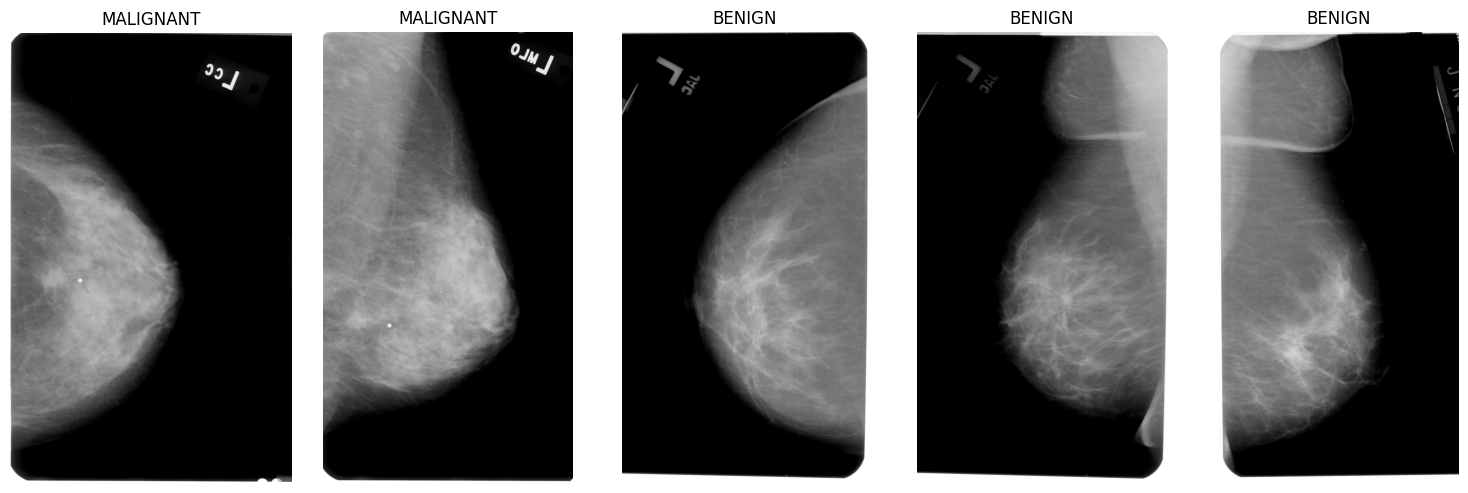

Cropped Mammograms:

(515, 431, 3)
(292, 256, 3)
(466, 423, 3)
(427, 422, 3)
(399, 465, 3)


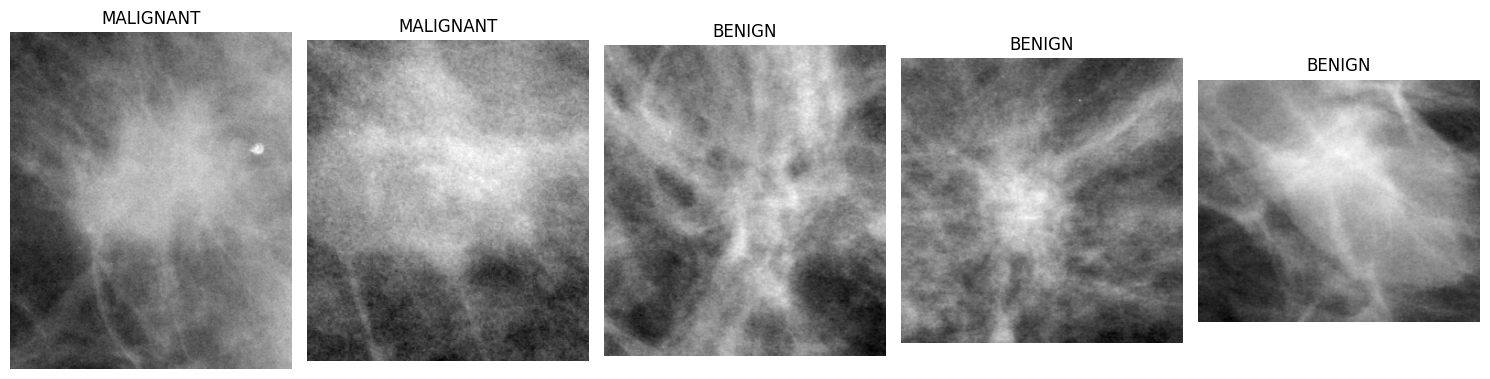

ROI_mask:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


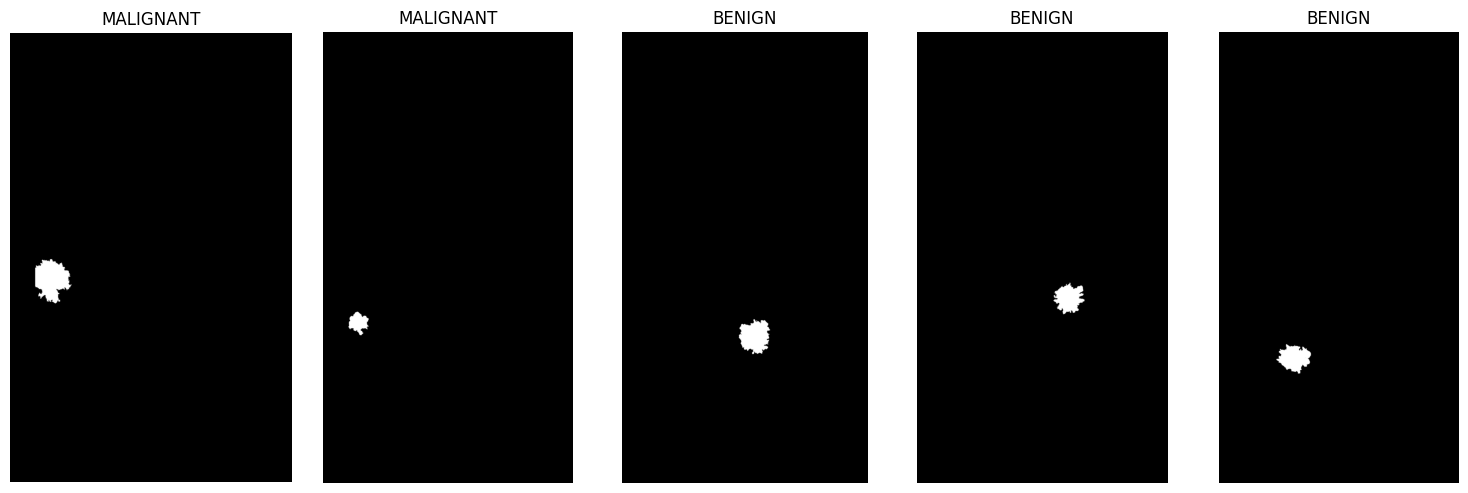

In [24]:
print('Full Mammograms:\n')
display_images(mass_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI_mask_file_path', 5)

Full Mammograms:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


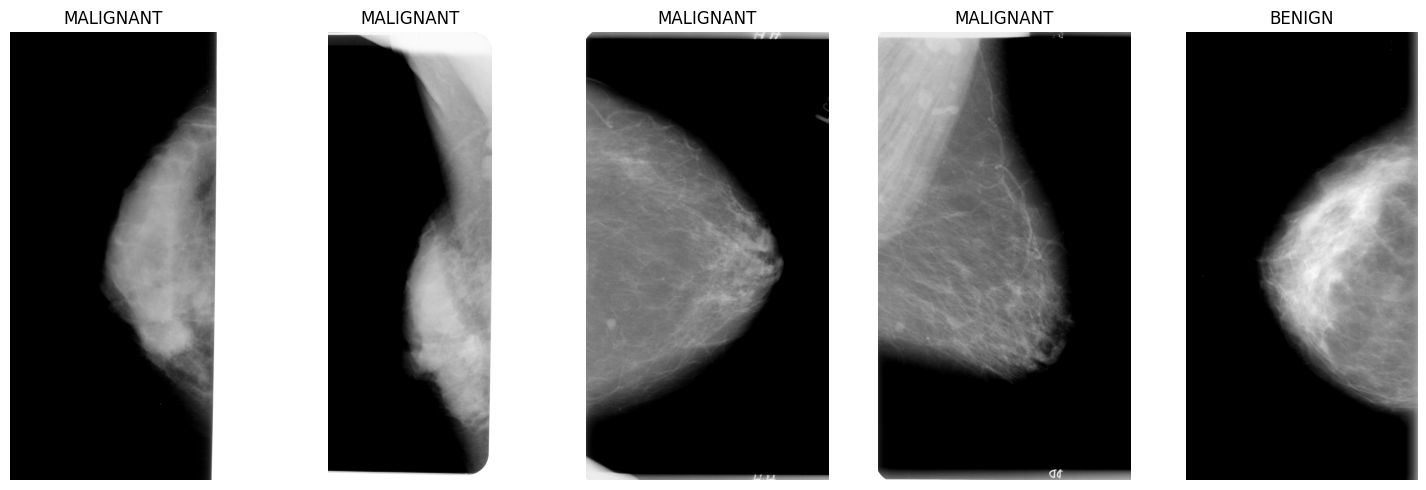

Cropped Mammograms:

(384, 385, 3)
(369, 328, 3)
(214, 195, 3)
(220, 225, 3)
(405, 376, 3)


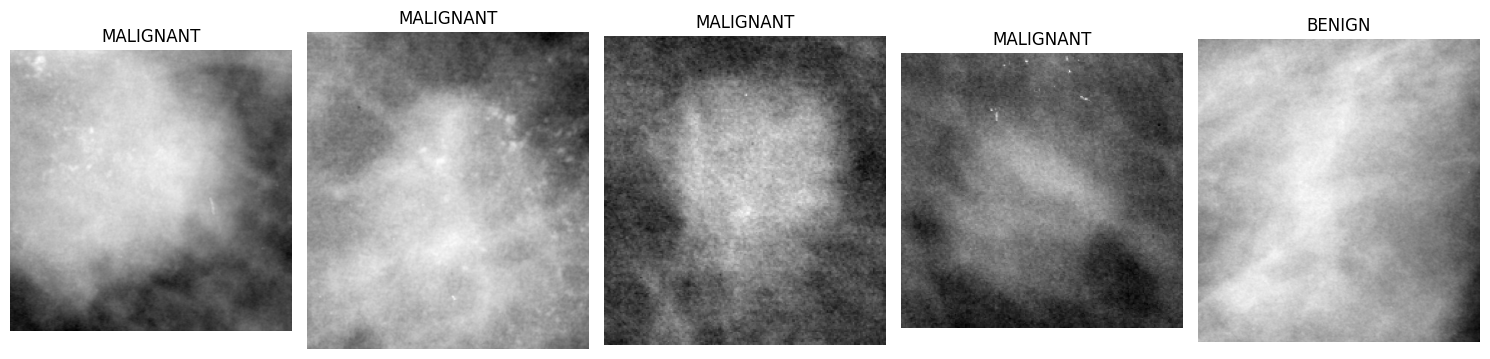

ROI_mask:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


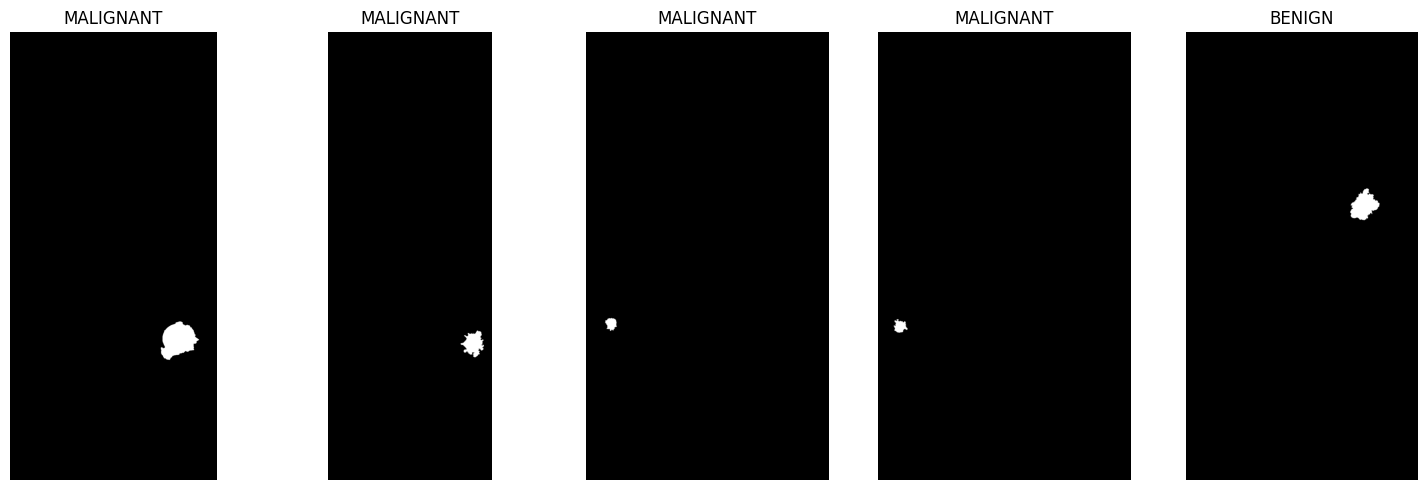

In [27]:
print('Full Mammograms:\n')
display_images(mass_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_test, 'ROI_mask_file_path', 5)

Full Mammograms:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


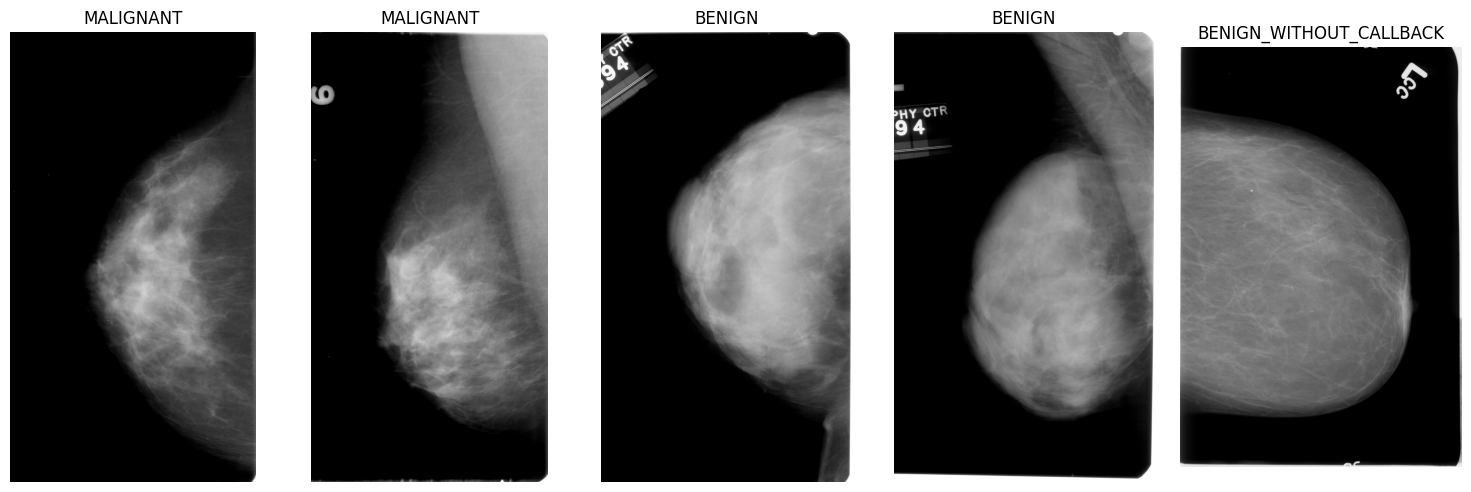

Cropped Mammograms:

(589, 677, 3)
(549, 681, 3)
(681, 577, 3)
(689, 761, 3)
(161, 177, 3)


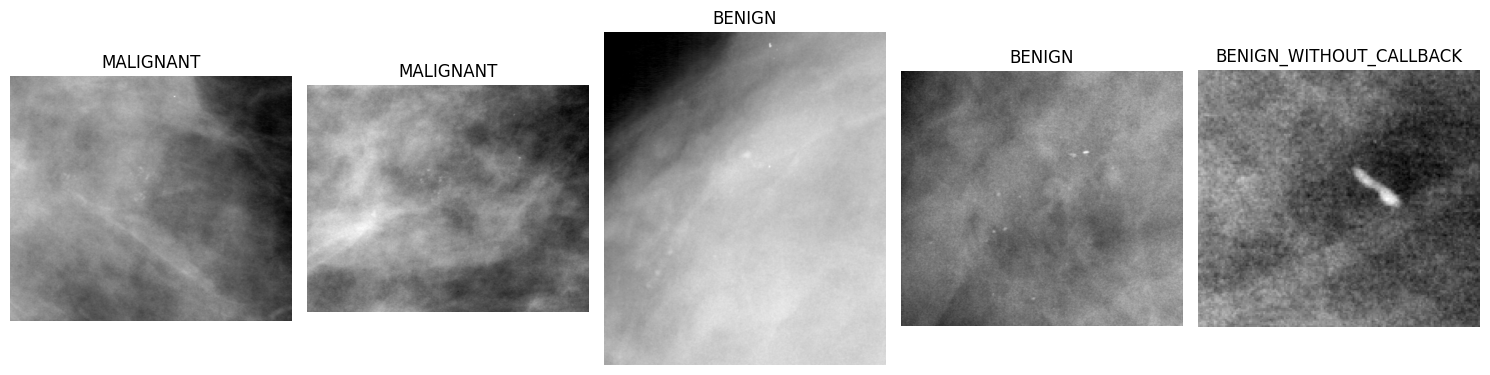

ROI_mask:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


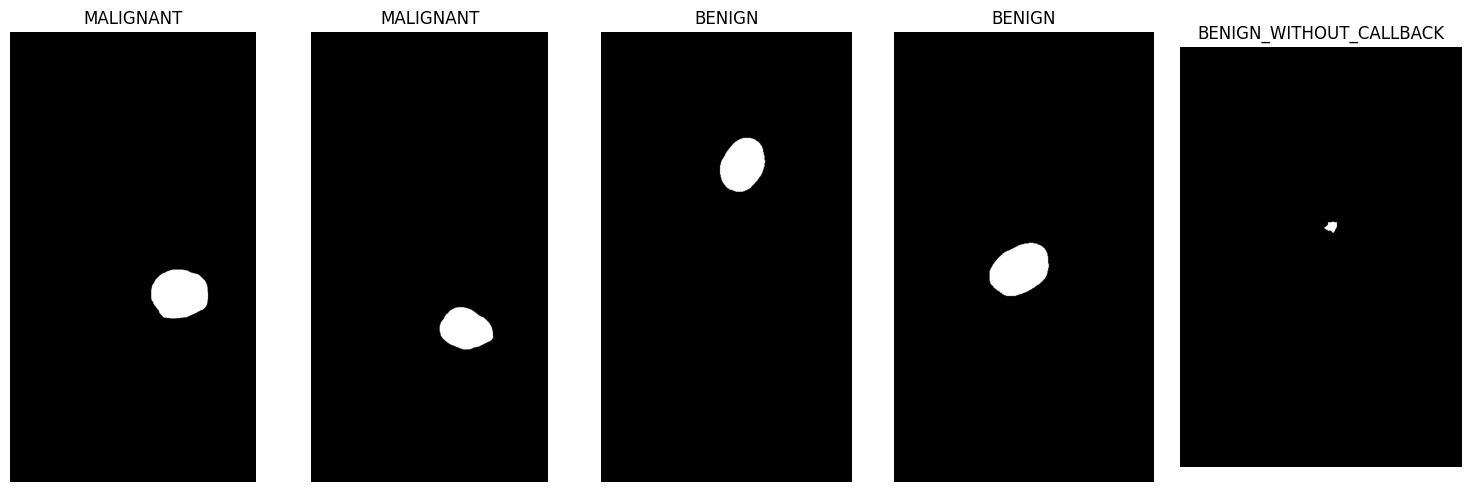

In [28]:
print('Full Mammograms:\n')
display_images(calc_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_train, 'ROI_mask_file_path', 5)

Combining the datasets into one.

In [30]:
# full_dataset = pd.concat([mass_train, mass_test, calc_train, calc_test], axis=0)
# try next time

full_dataset = pd.concat([calc_train, calc_test], axis=0)

In [31]:
len(full_dataset)

1872

In [32]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

In [33]:
target_size = (224, 224, 3)

# Apply class mapper to pathology column
full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)

full_images = np.array(full_dataset[full_dataset["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset[full_dataset["image_file_path"].notna()]["labels"].tolist())

/tmp/ipykernel_30/1650799513.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


In [34]:
len(full_images)

1588

In [35]:
# If full_labels is a NumPy array, convert it to a Pandas series
full_labels_series = pd.Series(full_labels)

# Count the occurrences of each class
label_counts = full_labels_series.value_counts()

# Assuming 0 = benign and 1 = malignant
benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)

print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

Benign images: 1018
Malignant images: 570


In [36]:
num_classes = len(full_dataset['labels'].unique())
num_classes

2

In [37]:
class_names = ['Benign', 'Malignant']

In [38]:
# Check the distribution of labels
label_counts = full_dataset['labels'].value_counts()
print(label_counts)

labels
0    1199
1     673
Name: count, dtype: int64


In [39]:
# Define a function for data augmentation
def augment_image(image):
    # Apply data augmentation using tf.image functions
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

# Function to resize image to (224, 224, 3)
def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])

# Function to balance classes by augmenting images
def copy_images_with_unique_filenames(images, labels, source, destination, target_count=None):
    """
    Copy images from source to destination in subfolders '0' and '1',
    ensuring unique filenames and applying data augmentation and balancing.
    """
    benign_images = 0
    malignant_images = 0
    skipped_images = []

    # Create the destination subfolders '0' and '1'
    category_dest_dir_zero = os.path.join(destination, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)

    category_dest_dir_one = os.path.join(destination, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)

    benign_images_list = []
    malignant_images_list = []

    for i, (image, label) in enumerate(zip(images, labels)):
#         img_name = data_frame.REFNUM[i]
#         abs_path = os.path.join(source, img_name + '.pgm')

        if os.path.exists(image):
            try:
                # Generate a unique filename
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"
        
                # Open the image using PIL
                with Image.open(image) as img:
                    # Convert the image to RGB mode (for saving as JPEG)
                    img = img.convert('RGB')
                    # Augment the image (convert it to a Tensor first)
                    img_tensor = tf.convert_to_tensor(img)
                    # Resize the image to (224, 224, 3)
                    resized_img_tensor = resize_image(img_tensor)
                    augmented_image_tensor = augment_image(resized_img_tensor)
                    # Convert Tensor back to PIL image for saving
                    augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)

                    if label == 0:
                        benign_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_zero, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        benign_images += 1

                    elif label == 1:
                        malignant_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_one, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        malignant_images += 1
                        
#                 del img, img_tensor, resized_img_tensor, augmented_image_tensor, augmented_image
#                 gc.collect()
            except Exception as e:
                print(f"Error copying image {image}: {e}")
                skipped_images.append(image)
        else:
            print(f"Image not found: {image}")
            skipped_images.append(image)

    # If balancing is needed, duplicate/augment images from the smaller class
    benign_count = len(benign_images_list)
    malignant_count = len(malignant_images_list)

    if benign_count < malignant_count:
#         augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count - benign_count)
        augment_and_save_images(benign_images_list, category_dest_dir_zero, malignant_count - benign_count)

    elif malignant_count < benign_count:
        augment_and_save_images(malignant_images_list, category_dest_dir_one, benign_count - malignant_count)

    augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count)
    augment_and_save_images(malignant_images_list, category_dest_dir_one, target_count)

    print(f"\nCopying complete.")
    print(f"Benign images copied (label 0): {benign_images}")
    print(f"Benign count (label 0): {benign_count}")
    print(f"Malignant images copied (label 1): {malignant_images}")
    print(f"Malignant count (label 1): {malignant_count}")
    print(f"Total skipped images: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)
            

# Function to augment and save images to balance the dataset
def augment_and_save_images(images_list, destination_dir, num_augments):
    """
    Augment and save images to balance the dataset.
    """
    for i in range(num_augments):
        img_name = random.choice(images_list)
        abs_path = os.path.join(destination_dir, img_name)

        try:
            with Image.open(abs_path) as img:
                img = img.convert('RGB')
                # Augment the image
                img_tensor = tf.convert_to_tensor(img)
                # Resize the image
#                 resized_img_tensor = resize_image(img_tensor)
                augmented_image_tensor = augment_image(img_tensor)
                # Convert Tensor back to PIL image for saving
                augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)
                # Remove the original extension from img_name 1-285.jpg --> 1-285
                img_name_without_ext = os.path.splitext(img_name)[0]
                # Save augmented image with a unique name
                augmented_image.save(os.path.join(destination_dir, img_name_without_ext + f'_aug{i}.jpg'), 'JPEG')
            
        except Exception as e:
            print(f"Error augmenting image {abs_path}: {e}")

source_dir = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
destination_dir = "/kaggle/working/merged_images"

# target_count=0 meaning no Augmentation, There's just Data-Balance
target_count = (len(full_labels) * 3) - len(full_labels)
copy_images_with_unique_filenames(full_images, full_labels, source_dir, destination_dir, target_count)


Copying complete.
Benign images copied (label 0): 1018
Benign count (label 0): 1018
Malignant images copied (label 1): 570
Malignant count (label 1): 570
Total skipped images: 0


In [40]:
# Check the number of images in each class folder after merging
zero_class_count = len(os.listdir("/kaggle/working/merged_images/0"))
one_class_count  = len(os.listdir("/kaggle/working/merged_images/1"))

print(f"Number of images in class 0: {zero_class_count}")
print(f"Number of images in class 1: {one_class_count}")

Number of images in class 0: 4194
Number of images in class 1: 4194


In [41]:
import tensorflow as tf

data_dir = '/kaggle/working/merged_images'  # Update with the dataset path

# Create a dataset for the entire data to use for split
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=13
)
# Calculate the total number of samples
total_samples = tf.data.experimental.cardinality(full_dataset).numpy()

train_size = int(0.8 * total_samples)                 # 70% for training
val_size   = int(0.15 * total_samples)                # 20% for validation
test_size = total_samples - train_size - val_size     # 10% for testing

# Create train, validation, and test datasets
train_dataset       = full_dataset.take(train_size)
validation_dataset  = full_dataset.skip(train_size).take(val_size)
test_dataset        = full_dataset.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each dataset
print(f"Train samples:      {train_size}     batches(13) ==> {train_size*13}")
print(f"Validation samples: {val_size}       batches(13) ==> {val_size*13}")
print(f"Test samples:       {test_size}      batches(13) ==> {test_size*13}")


Found 8388 files belonging to 2 classes.
Train samples:      516     batches(13) ==> 6708
Validation samples: 96       batches(13) ==> 1248
Test samples:       34      batches(13) ==> 442


In [41]:
from tensorflow.keras.applications import ResNet50

def try_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 50.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    
    # # Clear the base model from memory if needed (optional)
    # del model_dict, base_model, from_index, x, predictions;    gc.collect()
    return model

In [42]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

trymodel = try_model()

trymodel.compile(optimizer=Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])  # Compile the model
trymodel.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 23,462,402 (89.50 MB)

 Non-trainable params: 2,225,536 (8.49 MB)

In [43]:
history = trymodel.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size=13,
            epochs=7
        )

Epoch 1/7


I0000 00:00:1733636363.508021     113 service.cc:145] XLA service 0x7ec064014910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733636363.508105     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/516 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.4231 - loss: 1.2611 - precision: 0.4231 - recall: 0.4231   

I0000 00:00:1733636377.356530     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1733636377.381127     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.7121 - loss: 0.5927 - precision: 0.7121 - recall: 0.7121 - val_accuracy: 0.8718 - val_loss: 0.3084 - val_precision: 0.8718 - val_recall: 0.8718
Epoch 2/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.9157 - loss: 0.2251 - precision: 0.9157 - recall: 0.9157 - val_accuracy: 0.8854 - val_loss: 0.3479 - val_precision: 0.8854 - val_recall: 0.8854
Epoch 3/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.9550 - loss: 0.1274 - precision: 0.9550 - recall: 0.9550 - val_accuracy: 0.8998 - val_loss: 0.3532 - val_precision: 0.8998 - val_recall: 0.8998
Epoch 4/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.9592 - loss: 0.0982 - precision: 0.9592 - recall: 0.9592 - val_accuracy: 0.9623 - val_loss: 0.1283 - val_precision: 0.9623 - val_recall: 0.9623
Epoch 5/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9767 - loss: 0.0712 - precision: 0.9767 - recall: 0.9767 - val_accuracy: 0.9030 - val_loss: 0.3598 

## Moving onto our second model!

In [44]:
# Define the second model with adjusted hyperparameters
def try_model_v2():
    base_model_v2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model_v2.layers:
        layer.trainable = False

    # Unfreeze 60% of layers instead of 50%
    from_index_v2 = int(np.round((len(base_model_v2.layers) - 1) * (1.0 - 60.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model_v2.layers[from_index_v2:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x_v2 = base_model_v2.output
    x_v2 = GlobalAveragePooling2D()(x_v2)
    x_v2 = Dense(512, activation='relu')(x_v2)  # Reduced Dense layer size from 1024 to 512
    x_v2 = Dropout(0.3)(x_v2)  # Lowered dropout rate from 0.5 to 0.3
    predictions_v2 = Dense(2, activation='softmax')(x_v2)  # Assuming binary classification

    model_v2 = Model(inputs=base_model_v2.input, outputs=predictions_v2)
    
    return model_v2

# Create and compile the second model
trymodel_v2 = try_model_v2()
trymodel_v2.compile(optimizer=Adam(learning_rate=5e-5),  # Adjusted learning rate to 5e-5
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(name='precision_v2'), Recall(name='recall_v2')])


In [45]:
# Train the second model
history_v2 = trymodel_v2.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size=13,
            epochs=7
        )

# Summarize the second model
trymodel_v2.summary()

Epoch 1/7
  2/516 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.5000 - loss: 0.8915 - precision_v2: 0.5000 - recall_v2: 0.5000   

I0000 00:00:1733636648.948658     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



516/516 ━━━━━━━━━━━━━━━━━━━━ 67s 68ms/step - accuracy: 0.7247 - loss: 0.5396 - precision_v2: 0.7247 - recall_v2: 0.7247 - val_accuracy: 0.9054 - val_loss: 0.2624 - val_precision_v2: 0.9054 - val_recall_v2: 0.9054
Epoch 2/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.9391 - loss: 0.1637 - precision_v2: 0.9391 - recall_v2: 0.9391 - val_accuracy: 0.9391 - val_loss: 0.1721 - val_precision_v2: 0.9391 - val_recall_v2: 0.9391
Epoch 3/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.9815 - loss: 0.0573 - precision_v2: 0.9815 - recall_v2: 0.9815 - val_accuracy: 0.9399 - val_loss: 0.1713 - val_precision_v2: 0.9399 - val_recall_v2: 0.9399
Epoch 5/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9840 - loss: 0.0511 - precision_v2: 0.9840 - recall_v2: 0.9840 - val_accuracy: 0.9439 - val_loss: 0.1734 - val_precision_v2: 0.9439 - val_recall_v2: 0.9439
Epoch 6/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.9869 - loss: 0.0350 - precision_v2: 0.9869 - recall

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 71,468,936 (272.63 MB)

 Trainable params: 23,415,554 (89.32 MB)

 Non-trainable params: 1,222,272 (4.66 MB)

 Optimizer params: 46,831,110 (178.65 MB)

In [40]:
import matplotlib.pyplot as plt

# Plot the validation loss
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.title('Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_v2.history['accuracy'], label='Training Accuracy')
plt.title('Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: name 'history_v2' is not defined

## Lastly, our third model!

In [47]:
# Define the third model with different hyperparameters
def try_model_v3():
    base_model_v3 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model_v3.layers:
        layer.trainable = False

    # Unfreeze 70% of layers (more layers unfreezed compared to v1 and v2)
    from_index_v3 = int(np.round((len(base_model_v3.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model_v3.layers[from_index_v3:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x_v3 = base_model_v3.output
    x_v3 = GlobalAveragePooling2D()(x_v3)
    x_v3 = Dense(1024, activation='relu')(x_v3)  # Return Dense layer size to 1024
    x_v3 = Dropout(0.4)(x_v3)  # Moderate dropout rate (between v1 and v2)
    predictions_v3 = Dense(2, activation='softmax')(x_v3)  # Assuming binary classification

    model_v3 = Model(inputs=base_model_v3.input, outputs=predictions_v3)
    
    return model_v3

# Create and compile the third model
trymodel_v3 = try_model_v3()
trymodel_v3.compile(optimizer=RMSprop(learning_rate=1e-4),  # Change optimizer to RMSprop and learning rate back to 1e-4
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(name='precision_v3'), Recall(name='recall_v3')])



In [48]:
# Train the third model
history_v3 = trymodel_v3.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size=13,
            epochs=7
        )

# Summarize the third model
trymodel_v3.summary()

Epoch 1/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.6969 - loss: 0.6439 - precision_v3: 0.6969 - recall_v3: 0.6969 - val_accuracy: 0.8486 - val_loss: 0.4491 - val_precision_v3: 0.8486 - val_recall_v3: 0.8486
Epoch 2/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.8852 - loss: 0.2862 - precision_v3: 0.8852 - recall_v3: 0.8852 - val_accuracy: 0.8413 - val_loss: 0.7913 - val_precision_v3: 0.8413 - val_recall_v3: 0.8413
Epoch 3/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9501 - loss: 0.1444 - precision_v3: 0.9501 - recall_v3: 0.9501 - val_accuracy: 0.7428 - val_loss: 2.2098 - val_precision_v3: 0.7428 - val_recall_v3: 0.7428
Epoch 4/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9695 - loss: 0.0884 - precision_v3: 0.9695 - recall_v3: 0.9695 - val_accuracy: 0.8902 - val_loss: 0.6154 - val_precision_v3: 0.8902 - val_recall_v3: 0.8902
Epoch 5/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9679 - loss: 0.0878 - precision_v3: 0.967

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 50,649,606 (193.21 MB)

 Trainable params: 24,961,666 (95.22 MB)

 Non-trainable params: 726,272 (2.77 MB)

 Optimizer params: 24,961,668 (95.22 MB)

In [51]:
# Compare the validation precision and recall to determine the best model
best_model = "Model 1"
best_val_precision = max(history.history['val_precision'], history_v2.history['val_precision_v2'], history_v3.history['val_precision_v3'])
best_val_recall = max(history.history['val_recall'], history_v2.history['val_recall_v2'], history_v3.history['val_recall_v3'])

# Display the best model based on precision and recall
if best_val_precision > best_val_recall:
    best_model = "Model 1"
elif best_val_precision < best_val_recall:
    best_model = "Model 2"
else:
    best_model = "Model 3"

print(f"The best model is: {best_model}")


The best model is: Model 3


In [41]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import numpy as np

def try_model():
    # Load the base model with MobileNet
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 50.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model
trymodel = try_model()

# Compile the model
trymodel.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])



17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [44]:


# Train the model
history_V = trymodel.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=13,
    epochs=7
)


Epoch 1/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9681 - loss: 0.0840 - precision: 0.9681 - recall: 0.9681 - val_accuracy: 0.7925 - val_loss: 0.6689 - val_precision: 0.7925 - val_recall: 0.7925
Epoch 2/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9763 - loss: 0.0705 - precision: 0.9763 - recall: 0.9763 - val_accuracy: 0.9311 - val_loss: 0.2470 - val_precision: 0.9311 - val_recall: 0.9311
Epoch 3/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9770 - loss: 0.0672 - precision: 0.9770 - recall: 0.9770 - val_accuracy: 0.8774 - val_loss: 0.5063 - val_precision: 0.8774 - val_recall: 0.8774
Epoch 4/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9819 - loss: 0.0554 - precision: 0.9819 - recall: 0.9819 - val_accuracy: 0.8958 - val_loss: 0.4629 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 5/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9770 - loss: 0.0640 - precision: 0.9770 - recall: 0.9770 - val_accuracy: 0.9255 - val_los

In [42]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import numpy as np

def try_model_vgg16():
    # Load the base model with VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 50.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model
trymodel_vgg16 = try_model_vgg16()

# Compile the model
trymodel_vgg16.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [43]:
# Train the model
history_V2 = trymodel_vgg16.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=13,
    epochs=7
)

Epoch 1/7


I0000 00:00:1734413169.265012     101 service.cc:145] XLA service 0x7e0c6c0093b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734413169.265100     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/516 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.3462 - loss: 3.0145 - precision: 0.3462 - recall: 0.3462  

I0000 00:00:1734413177.402151     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1734413177.408351     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 46s 68ms/step - accuracy: 0.5652 - loss: 0.7552 - precision: 0.5652 - recall: 0.5652 - val_accuracy: 0.6474 - val_loss: 0.6409 - val_precision: 0.6474 - val_recall: 0.6474
Epoch 2/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.6625 - loss: 0.6271 - precision: 0.6625 - recall: 0.6625 - val_accuracy: 0.7188 - val_loss: 0.5839 - val_precision: 0.7188 - val_recall: 0.7188
Epoch 3/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7327 - loss: 0.5421 - precision: 0.7327 - recall: 0.7327 - val_accuracy: 0.7396 - val_loss: 0.4938 - val_precision: 0.7396 - val_recall: 0.7396
Epoch 4/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7803 - loss: 0.4546 - precision: 0.7803 - recall: 0.7803 - val_accuracy: 0.7861 - val_loss: 0.4444 - val_precision: 0.7861 - val_recall: 0.7861
Epoch 5/7
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.8155 - loss: 0.3880 - precision: 0.8155 - recall: 0.8155 - val_accuracy: 0.8446 - val_loss: 0.3528 

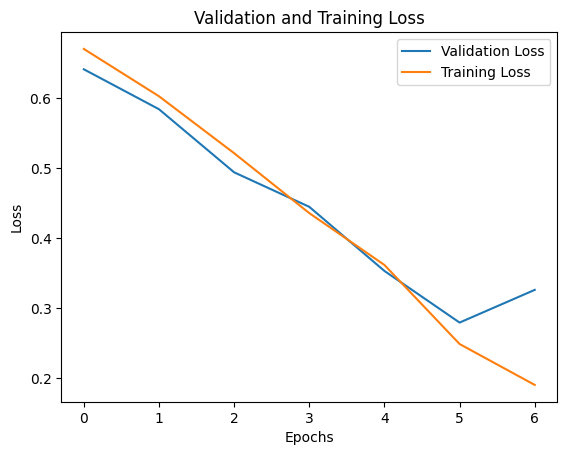

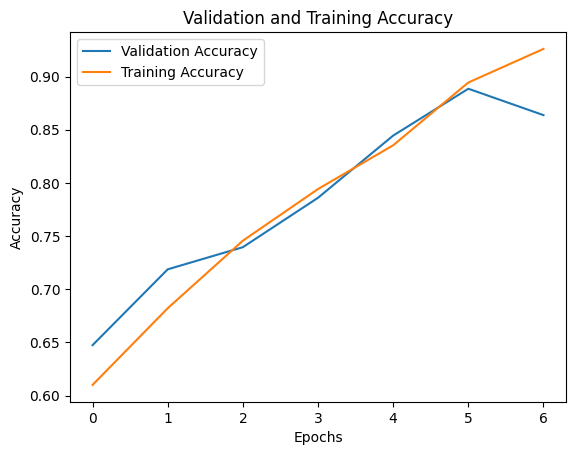

In [46]:
import matplotlib.pyplot as plt

# Plot the validation loss
plt.plot(history_V2.history['val_loss'], label='Validation Loss')
plt.plot(history_V2.history['loss'], label='Training Loss')
plt.title('Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.plot(history_V2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_V2.history['accuracy'], label='Training Accuracy')
plt.title('Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
from tensorflow.keras.models import load_model

# Save the third model (v3) to a file
trymodel_vgg16.save('model_vgg16.h5')

# Optionally, load the model back to verify
trymodel_vgg16 = load_model('model_vgg16.h5')
